# Why Are Our Customers Churning?

**1. Project Plan**<br>
**2. Acquire and Split Data**<br>
**3. Explore Data**<br>
**4. Create a Baseline Model**<br>
**5. Create and Compare Different Models**<br>
**6. Predict on Test Model**<br>
**7. Exporting CSV with Predictions**

## 1. Project Plan

### Background

Our team leader wants us to find out why our customers are churning.

> Our team lead would like us to take a look at some of our recent customer data. We've been tasked with identifying areas that represent high customer churn.

> Aside from the more general question, *why are our customers churning?* Some other questions we will look to answer: Is there a price threshold for specific services where the likelihood of churn increases? Is their a negative impact once the price for those services goes past that point? If so, what is that point for what service(s)? Among numerous other possible questions.

> For this particular project she would like to see our code documentation and commenting buttoned-up. In addition, she'd like us to not leave any individual numbers or figures displayed in isolation. Adding context to these situations are necessary.

### Goals

To identify as many different customer subgroups that have a propensity to churn more than others. Our target audience is our team lead, however, she will be presenting these findings to the Senior Leadership Team. We will need to keep this final audience in mind with regards to report readability, etc. We will need to communicate in a more concise and clear manner.

The deliverables for this project are the following data assets:

1. Report detailing our analysis in an .ipynb format
2. A CSV with the customer_id, probability of churn, and the prediction of churn
3. Slide Deck explaining our analysis with the SLT audience in mind
4. All .py files that are necessary to reproducible work
5. Detailed README on a Github and repo containing all files for this project

### Data Dictionary for Selected Features

#### *Target Variable*:

**churn** - defines whether or not the customer is still with telco: 0 == still with telco, 1 == they have churned


#### *Independent Variables*:

**gender** - gender identity of customer - 0 = female, 1 = male

**senior_citizen** - if the customer is a senior - 0 = senior citizen, 1 = not senior citizen

**online_security** - if the customer has online security through telco - 0 = No, 1 = No Internet Service, 2 = Yes

**online_backup** - if the customer has online backup through telco - 0 = No, 1 = No Internet Service, 2 = Yes

**device_protection** - if the customer has device protection through telco - 0 = No, 1 = No Internet Service, 2 = Yes

**tech_support** - if the customer has tech support through telco - 0 = No, 1 = No Internet Service, 2 = Yes

**streaming_tv** - if the cusomter has streaming tv service through telco - 0 = No, 1 = No Internet Service, 2 = Yes

**streaming_movies** - if the cusomter has streaming movie service through telco - 0 = No, 1 = No Internet Service, 2 = Yes

**paperless_billing** - if the customer has elected to have a paperless billing format - 0 = No, 1 =Yes

**monthly_charges** - the monthly charges per customer for all services - represented as a float, calculated in USD

**total_charges** - the total lifetime charges per customer for all services - represented as a float, calculated in USD

**tenure_years** - tenure of each customer - represented in total years, used the tenure (calculated in months) column from original data pull then divided by 12.

**phone_and_multi_line** - a combination of whether a customer has a phone line, and if they do, do they have multiple lines (used the phone_service and multipe_line columns from original pull) - 0 = No phone lines, 1 = Yes, but only one line, 2 = Yes, multiple lines

**partner_and_dependents** - a combination of whether a customer has a partner or dependents (used the partner and dependents columns from original pull) - 0 = No partner and No dependents, 1 = Yes, a partner and No dependents, 2 = No partner and Yes, dependents, 3 = Yes, partner and Yes, dependents

**Electronic check** - the customer pays with Electronic check, one hot encoded from the payment_types column from original pull - 0 = No, 1 = Yes

**Mailed check** -the customer pays with Mailed check, one hot encoded from the payment_types column from original pull - 0 = No, 1 = Yes

**Credit card (automatic)** - the customer pays with Credit card, one hot encoded from the payment_types column from original pull - 0 = No, 1 = Yes

**Bank transfer (automatic)** - the customer pays with Bank transfer, one hot encoded from the payment_types column from original pull - 0 = No, 1 = Yes

**DSL** - the customer has DSL internet service, one hot encoded from the internet_types column from original pull - 0 = No, 1 = Yes

**Fiber optic** - the customer has Fiber optic internet service, one hot encoded from the internet_types column from original pull - 0 = No, 1 = Yes

**None** - the customer does not have internet service, one hot encoded from the internet_types column from original pull - 0 = No, 1 = Yes

**Month-to-month** - the customer pays Month-to-month, one hot encoded from the contract_types column from original pull - 0 = No, 1 = Yes

**One year** - the customer pays Month-to-month, one hot encoded from the contract_types column from original pull - 0 = No, 1 = Yes

**Two year** - the customer pays Month-to-month, one hot encoded from the contract_types column from original pull - 0 = No, 1 = Yes

#### *Data Scaling*:

**Min/Max Scaler** - The deliverables requires we proved a model that preforms better than the baseline at predicting customer churn. We'll be using Classification models to make this prediciton. It's possible we'll need to scale the data, generally; however, a model like K Nearest Neighbors requires scaling, so we'll at least be scaling when testing that model.

In [33]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import sklearn.impute
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import env
import acquire
import prepare

pd.set_option('display.max_columns', None)

## 2. Acquire and Split Data

In [3]:
# We're be pulling the telco data from our SQL servers. You'll need the acquire.py file and an env.py file for
# this data pull.

telco = acquire.get_telco_data()

### Let's take a look at the data

In [34]:
telco.head(10)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.90,542.4,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,No,No,No,Yes,Yes,Yes,Yes,69.40,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,No,Yes,No,No,No,No,No,Yes,48.20,340.35,No,Month-to-month,DSL,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,No phone service,No,No,No,No,No,No,Yes,25.10,25.1,Yes,Month-to-month,DSL,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,Yes,No,No,No,No,No,No,30.50,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)
5,1,1,1,0067-DKWBL,Male,1,No,No,2,Yes,No,Yes,No,No,No,No,No,Yes,49.25,91.1,Yes,Month-to-month,DSL,Electronic check
6,2,1,1,0076-LVEPS,Male,0,No,Yes,29,No,No phone service,Yes,Yes,Yes,Yes,No,No,Yes,45.00,1242.45,No,Month-to-month,DSL,Mailed check
7,2,1,1,0082-LDZUE,Male,0,No,No,1,Yes,No,No,No,No,No,No,No,Yes,44.30,44.3,No,Month-to-month,DSL,Mailed check
8,1,1,1,0096-BXERS,Female,0,Yes,No,6,Yes,Yes,No,No,No,No,No,No,No,50.35,314.55,No,Month-to-month,DSL,Electronic check
9,2,1,1,0096-FCPUF,Male,0,No,No,30,Yes,Yes,Yes,No,No,No,No,Yes,Yes,64.50,1888.45,No,Month-to-month,DSL,Mailed check


In [37]:
telco.shape

(7043, 24)

In [35]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [36]:
telco.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


#### Takeaways

- total_charges should be in the above .describe(), but it is the wrong dtype

- After seveeral attempts to change total_charges into a float, we discovered there were some empty spaces in the cell, so once we replace those, we can now see a few missing values there as well, and we can change the dtype

- We decided to drop the 0 values (found in the total_charges column) from the data set, because we have plenty of data points for our analysis, and these customers haven't even had a chance to churn yet.

- After viewing the data post this change, we felt like keeping the customer_id was vital, but we'd like to 'take it out' of the data for future scaling, exploration, etc. So, we will set the index with the customer_id

- We have a ton of variables that are related, so we're looking to combine a few columns into single 'encoded' variables, the first combination was whether a customer has phone service at all, and if they do do they have 1 or more lines, so we'll put a 0 for none, 1 for yes, but 1 line, 2 for yes and more than 1 line

- We will look at the dependent and partner columns. With these we'll address them similar to before, 0 for 'no and no', 1 for 'yes and no', 2 for 'no and yes', and 3 for 'yes and yes'.

- We felt that dropping the type_id fields for payment, internet_service, and contract was appropriate becuase these are artifacts of the joining process during SQL pull

- We're drop the columns partner, dependents, phone_service, tenure, and multiple_lines, because we've added 'encoded' versions on the dataframe

- Now we need to encode our data for numerous columns: payment, internet_service, and contract_type. We will use the one hot encoder because we're not 'ranking' the different options - they are categorical in nature.

- Now that all the one hot encoded dataframes are ready to go with a *train, test split*. We'll split into train and test at 80/20, then split into train and validate at 80/20.

In [38]:
# We're now left with this code based on functions in the prepare.py file. They accomplish all items addresses
# above, and return all train, validate and test datasets.

X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_telco(telco)

In [41]:
print('   train: %d rows' % X_train.shape[0])
print('validate: %d rows' % X_validate.shape[0])
print('    test: %d rows' % X_test.shape[0])

   train: 4500 rows
validate: 1125 rows
    test: 1407 rows


In [39]:
X_train.head()

,gender,senior_citizen,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,tenure_years,phone_and_multi_line,partner_and_dependents,Electronic check,Mailed check,Credit card (automatic),Bank transfer (automatic),DSL,Fiber optic,None,Month-to-month,One year,Two year
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,
3714-JTVOV,0,1,2,0,0,0,0,0,1,74.15,3229.40,1,3.500000,1,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3049-SOLAY,0,0,0,0,0,0,2,2,1,95.20,292.85,1,0.250000,2,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5035-PGZXH,0,0,0,2,2,0,2,2,1,106.80,5914.40,0,4.666667,2,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1051-EQPZR,0,0,1,1,1,1,1,1,0,19.60,780.25,0,3.666667,1,3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
8755-OGKNA,0,0,1,1,1,1,1,1,0,19.50,1167.60,0,4.750000,1,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## 3. Explore Data

In [11]:
X_train.corr()

,gender,senior_citizen,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,tenure_years,phone_and_multi_line,partner_and_dependents,Electronic check,Mailed check,Credit card (automatic),Bank transfer (automatic),DSL,Fiber optic,None,Month-to-month,One year,Two year
gender,1.000000,0.000596,-0.008942,-0.013848,0.006885,-0.029079,-0.011879,-0.003863,-0.019508,-0.006086,0.008035,-0.004172,0.004998,0.007119,0.002279,-0.008996,-0.013346,0.005474,0.015892,-0.006819,0.000981,0.006698,-0.001055,0.009000,-0.007339
senior_citizen,0.000596,1.000000,-0.117105,-0.018954,-0.028216,-0.174685,0.024232,0.046669,0.162936,0.222478,0.097341,0.156382,0.009529,0.125163,-0.151981,-0.008456,-0.031439,0.175443,-0.159482,-0.120502,0.264619,-0.180429,0.142662,-0.039390,-0.127920
online_security,-0.008942,-0.117105,1.000000,0.184183,0.174590,0.283704,0.050905,0.061645,-0.149088,-0.046509,0.261381,-0.291187,0.334211,0.003747,0.165173,0.096398,0.128060,-0.250901,0.062591,0.145750,-0.245519,0.128162,-0.373038,0.125085,0.313477
online_backup,-0.013848,-0.018954,0.184183,1.000000,0.181171,0.210481,0.150048,0.142180,-0.007073,0.115711,0.374726,-0.198685,0.377728,0.109570,0.117780,0.103595,0.082017,-0.132835,-0.032748,0.005600,-0.051920,0.056262,-0.288375,0.121787,0.218462
device_protection,0.006885,-0.028216,0.174590,0.181171,1.000000,0.243138,0.279399,0.288624,-0.039807,0.155958,0.376124,-0.176043,0.366118,0.084642,0.123410,0.085856,0.141213,-0.147406,-0.057455,-0.007778,-0.040670,0.058133,-0.349486,0.133546,0.278123
tech_support,-0.029079,-0.174685,0.283704,0.210481,0.243138,1.000000,0.177468,0.166049,-0.114647,0.000760,0.283167,-0.286854,0.326478,0.007751,0.148327,0.098504,0.117702,-0.256431,0.077063,0.132788,-0.233830,0.129022,-0.409870,0.117087,0.363785
streaming_tv,-0.011879,0.024232,0.050905,0.150048,0.279399,0.177468,1.000000,0.454041,0.083329,0.351437,0.405177,-0.037381,0.301078,0.182385,0.095191,0.051622,0.046566,0.026664,-0.127291,-0.172903,0.159563,0.007092,-0.236530,0.089883,0.188707
streaming_movies,-0.003863,0.046669,0.061645,0.142180,0.288624,0.166049,0.454041,1.000000,0.077004,0.343587,0.401102,-0.034569,0.294345,0.164673,0.073686,0.046217,0.058148,0.014291,-0.119418,-0.163066,0.150586,0.006566,-0.229564,0.095498,0.175289
paperless_billing,-0.019508,0.162936,-0.149088,-0.007073,-0.039807,-0.114647,0.083329,0.077004,1.000000,0.337619,0.153314,0.185343,0.006180,0.120406,-0.089594,-0.007928,-0.023942,0.201361,-0.196835,-0.064024,0.319619,-0.312180,0.169372,-0.065443,-0.134099
monthly_charges,-0.006086,0.222478,-0.046509,0.115711,0.155958,0.000760,0.351437,0.343587,0.337619,1.000000,0.653667,0.199587,0.246102,0.493834,-0.035031,0.052390,0.011434,0.281561,-0.382318,-0.165292,0.787541,-0.760498,0.054071,0.014690,-0.076662


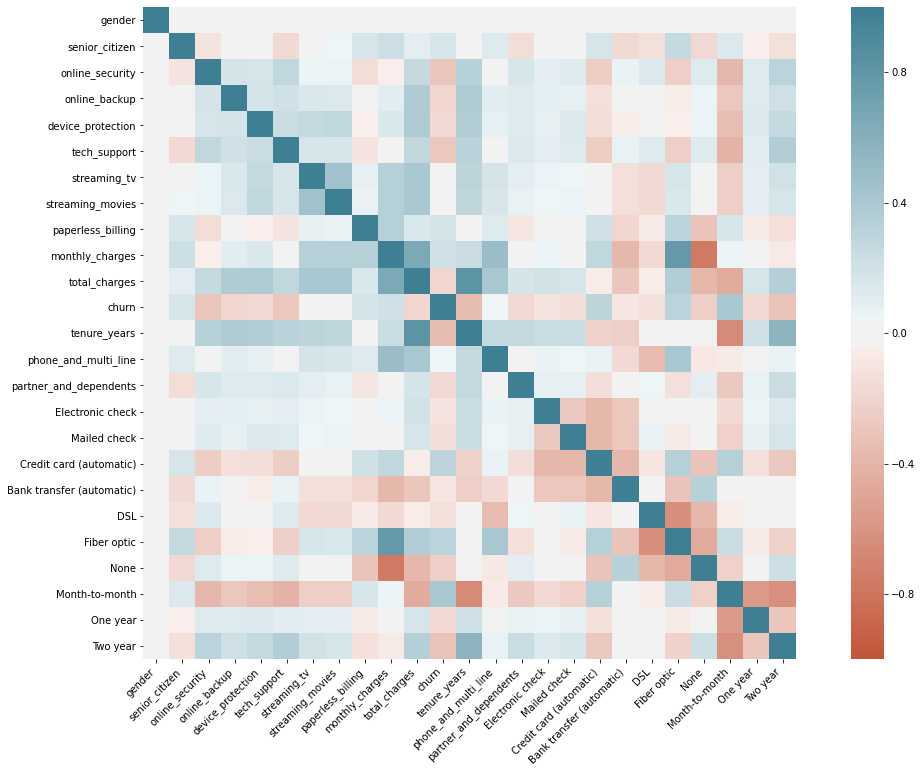

In [12]:
corr = X_train.corr()

plt.figure(figsize=(20,12))

ax = sns.heatmap(
    corr,
    #annot = True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

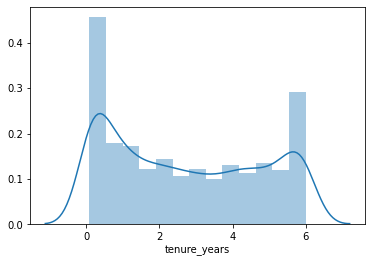

In [25]:
sns.distplot(X_train['tenure_years']);

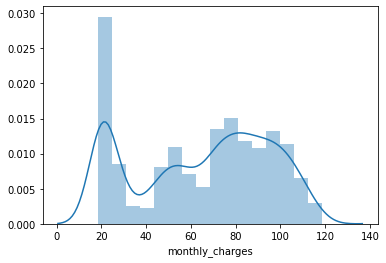

In [26]:
sns.distplot(X_train['monthly_charges']);

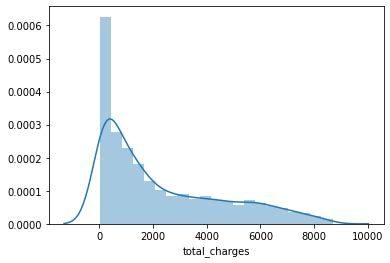

In [27]:
sns.distplot(X_train['total_charges']);